In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import classification_report

train/test split - https://medium.com/@pytorch_geometric/link-prediction-on-heterogeneous-graphs-with-pyg-6d5c29677c70

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_pickle('C:/research/adaptive learning/appmath.pkl')

In [5]:
df2=pd.read_csv('C:/research/adaptive learning/prereq_edges.csv')

In [6]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
       

In [7]:
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

In [8]:
for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

In [9]:
nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']

In [10]:
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [11]:


for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [12]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [13]:
df16=df[df.loGraphID==16].reset_index(drop=True)

In [14]:
df16=df16[~df16.correct.isna()]

In [15]:
difficulty=df16.groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})

In [16]:
difficulty

,atom_id,difficulty
0,0cdd8004-b809-49ae-aa59-fae9a0baa575,0.495935
1,113c2c7a-465f-439f-a05b-a2fa71dd4d73,0.867021
2,136d5e8f-ccef-4a13-873b-74e3b04daca0,0.591195
3,13db4de5-222b-436b-acac-32ca9a09e7fb,0.535326
4,14fc11f5-dcb5-499f-8f29-7013626bc29f,0.532258
...,...,...
80,f78b02ee-0bbc-4cc9-89b2-0efbd635850c,0.485030
81,f7956319-1ba4-46ca-9fd7-c461670cfee5,0.626822
82,f9a31b6c-a4f9-489d-9686-1a690ad8f053,0.643799
83,fe5b22c6-d86c-4192-afd4-2ab0995e9272,0.691358


In [17]:
df16=df16.merge(difficulty,how='left',on='atom_id')

<AxesSubplot:>

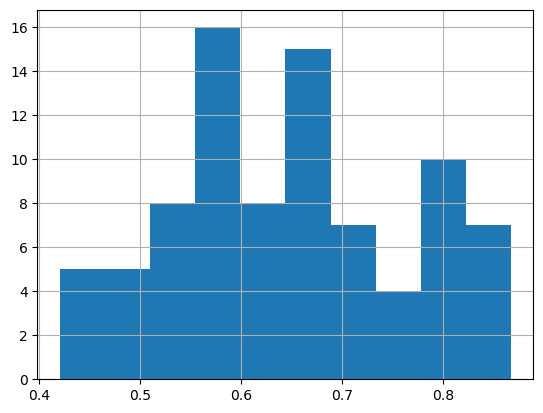

In [18]:
difficulty.difficulty.hist(bins=10)

# Assuming your DataFrame is called 'df'
student_ids = df['student_id'].unique()
num_students = len(student_ids)
data_list = []

for student_id in student_ids:
    # Filter data for each student
    student_data = df[df['student_id'] == student_id]

    # Get the unique question and learning objective IDs
    question_ids = student_data['question_id'].unique()
    learning_objectives = student_data['learning_objective'].unique()

    # Create dictionaries for mapping IDs to indices
    question_id_to_index = {q_id: i for i, q_id in enumerate(question_ids)}
    learning_objective_to_index = {lo: i for i, lo in enumerate(learning_objectives)}

    # Initialize node features and edges
    x = []  # Node features
    edge_index = [[], []]  # Edge indices
    y = []  # Target values (correctness)

    # Iterate over each question
    for idx, row in student_data.iterrows():
        # Get the node indices for the question and learning objective
        question_index = question_id_to_index[row['question_id']]
        objective_index = learning_objective_to_index[row['learning_objective']]

        # Append node features
        x.append([row['question_difficulty']])  # Question difficulty
        x.append([row['num_questions_for_learning_obj']])  # Number of questions for the learning objective

        # Append edge indices
        edge_index[0].append(question_index * 2)  # Outgoing edge from question
        edge_index[1].append((question_index * 2) + 1)  # Incoming edge to learning objective

        # Append target values
        y.append(row['correctness'])

    # Convert lists to tensors
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y)

    # Add the data to the list
    data_list.append(data)

# Create an InMemoryDataset from the data list
class StudentDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(StudentDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

dataset = StudentDataset('')


In [19]:
pd.DataFrame(df16.groupby('user_id')['atom_id'].nunique())[(pd.DataFrame(df16.groupby('user_id')['atom_id'].nunique())>50).atom_id]

,atom_id
user_id,
13c74562-c746-452b-8486-d869bd77d81e,54
19770dd7-05b6-4b15-9f9f-5e4a3db80be0,55
26052cc4-76b7-4461-8722-fa6976262914,64
266bc869-2a67-4ad5-a249-4241114e9f6d,57
29abcf88-6580-4304-bc4a-002ff5372ca9,58
2a77669b-b645-410e-ba76-9ae222dc3af3,53
36668830-a245-4efd-ad6c-cc8d3a54c339,59
436acb45-d00e-4326-aa91-962d9fe199a8,60
570b7ecf-d43d-4909-baf2-c49f45a36305,57


In [86]:
user='f49c42dd-5889-4831-8e5f-e8512aec4e66' 

In [116]:
loIndex={lo:i for i,lo in enumerate( df16.learning_objective_name.unique())}
df16['loIndex']=df16['learning_objective_name'].apply(lambda x: loIndex[x])

loMapping=df2[(df2.source_lo_title.isin(loIndex.keys())) | (df2.dest_lo_title.isin(loIndex.keys()))]
loMapping['source_index']=loMapping.source_lo_title.map(loIndex)
loMapping['dest_index']=loMapping.dest_lo_title.map(loIndex)
loEdgeMapping=loMapping[['source_index','dest_index']].reset_index(drop=True)
loEdgeIndex=loEdgeMapping.values.transpose()

C:\Users\mpathirana\AppData\Local\Temp\ipykernel_22100\2542482812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loMapping['source_index']=loMapping.source_lo_title.map(loIndex)
C:\Users\mpathirana\AppData\Local\Temp\ipykernel_22100\2542482812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loMapping['dest_index']=loMapping.dest_lo_title.map(loIndex)


In [118]:
df16.loIndex.unique()

array([0, 1, 2, 3], dtype=int64)

In [119]:
def user_dataset(user):  
    df16[df16.user_id==user].correct.value_counts()

    df16['correctBinary']=df16.correct*1

    df16.atom_id=df16.atom_id.astype(str)

    userDf=df16[df16.user_id==user]

    userDf=userDf.sort_values(by='interaction_end_time')

    atomIndex={atom:i for i,atom in enumerate( userDf.atom_id)}

    #loIndex={lo:i for i,lo in enumerate( userDf.learning_objective_name.unique())}

    #userDf['loIndex']=userDf['learning_objective_name'].apply(lambda x: loIndex[x])
    userDf['atomIndex']=np.arange(userDf.shape[0])

    atomsPerLO=userDf.groupby('loIndex')['atom_id'].count().to_dict()
    userDf['atomsPerLO']=userDf['loIndex'].apply(lambda x: atomsPerLO[x])

    edgeMap=userDf[['loIndex','atomIndex']]

    y=userDf.correctBinary.astype(int).to_numpy()

    #loMapping=df2[(df2.source_lo_title.isin(loIndex.keys())) | (df2.dest_lo_title.isin(loIndex.keys()))]

    #loMapping['source_index']=loMapping.source_lo_title.map(loIndex)
    #loMapping['dest_index']=loMapping.dest_lo_title.map(loIndex)

    #loEdgeMapping=loMapping[['source_index','dest_index']].reset_index(drop=True)

    #loEdgeIndex=loEdgeMapping.values.transpose()

    loAtomEdgeIndex=edgeMap.values.transpose()

    atomAtom=edgeMap.reset_index(drop=True)[['atomIndex']]

    atomAtom['nextAtom']=atomAtom.atomIndex.shift(-1)

    atomAtom=atomAtom.dropna()

    atomEdgeIndex=atomAtom.values.transpose()

    atomFeatures=userDf.difficulty.to_numpy().reshape(-1,1)

    #loFeatures=np.array(list(atomsPerLO.values())).reshape(-1,1)
    return  atomFeatures,loFeatures,loAtomEdgeIndex,atomEdgeIndex,y

In [88]:
from torch_geometric.data import HeteroData
import torch 


In [89]:
import torch_geometric.transforms as T

In [123]:
atomFeatures,loFeatures,loAtomEdgeIndex,atomEdgeIndex,y=user_dataset(userIds[8])

In [124]:
def generate_data(atomFeatures,loFeatures,loAtomEdgeIndex,loEdgeIndex,atomEdgeIndex,y):  
    data = HeteroData()
    data['atom'].x=torch.tensor(atomFeatures).float()
    data['lo'].x= torch.tensor(loFeatures).float()
    data['lo','lo_atom','atom'].edge_index=torch.from_numpy(loAtomEdgeIndex).long()
    data['lo','lo_lo','lo'].edge_index= torch.from_numpy(loEdgeIndex).long()
    data['atom','atom_atom','atom'].edge_index=torch.from_numpy(atomEdgeIndex).long()

    data['atom'].y=torch.from_numpy(y).long()


    #split=T.RandomNodeSplit(num_test =5)
    #data=split(data)

    size=y.shape[0]
    num_test_nodes =int(y.shape[0]*.35)
    some_indices = torch.randperm(size)[:num_test_nodes]


    test_mask = torch.zeros(y.shape[0], dtype=torch.bool)
    test_mask[some_indices] = True
    data['atom'].test_mask = test_mask

    train_mask = torch.ones(y.shape[0], dtype=torch.bool)
    train_mask[some_indices] = False
    data['atom'].train_mask = train_mask

    normalize=T.NormalizeFeatures()
    data=normalize(data)
    return data

In [125]:
data=generate_data(atomFeatures,loFeatures,loAtomEdgeIndex,loEdgeIndex,atomEdgeIndex,y)

In [126]:
data

HeteroData(
  atom={
    x=[18, 1],
    y=[18],
    test_mask=[18],
    train_mask=[18]
  },
  lo={ x=[4, 1] },
  (lo, lo_atom, atom)={ edge_index=[2, 18] },
  (lo, lo_lo, lo)={ edge_index=[2, 3] },
  (atom, atom_atom, atom)={ edge_index=[2, 17] }
)

In [93]:
print('data.has_isolated_nod : {}'.format(data.has_isolated_nodes()))
print('data.has_self_loops   : {}'.format(data.has_self_loops()))
print('data.is_undirected    : {}'.format(data.is_directed()))

data.has_isolated_nod : False
data.has_self_loops   : False
data.is_undirected    : True


In [95]:
data

HeteroData(
  atom={
    x=[93, 1],
    y=[93],
    test_mask=[93],
    train_mask=[93]
  },
  lo={ x=[4, 1] },
  (lo, lo_atom, atom)={ edge_index=[2, 93] },
  (lo, lo_lo, lo)={ edge_index=[2, 3] },
  (atom, atom_atom, atom)={ edge_index=[2, 92] }
)

In [94]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv, to_hetero

In [60]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.conv2 = SAGEConv((-1, -1), hidden_channels,requires_grad=False)
        self.conv3 = SAGEConv((-1, -1), out_channels,requires_grad=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=2)
model = to_hetero(model, data.metadata(), aggr='mean')

In [61]:
optimizer=torch.optim.Adam(model.parameters(),lr=.01,weight_decay=5e-4)
criterion=torch.nn.CrossEntropyLoss()
def train():
    model.train()
    optimizer.zero_grad()
    out=model(data.x_dict, data.edge_index_dict)
    #print(out)
    loss=criterion(out['atom'][data['atom'].train_mask],data['atom'].y[data['atom'].train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out=model(data.x_dict,data.edge_index_dict)
    #print(out)
    pred=out['atom'].argmax(dim=1)
    #print(out)
    test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
    test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())

   
    classificationReport=classification_report(data['atom'].y[data['atom'].test_mask],pred[data['atom'].test_mask])
    print(classificationReport)
    return test_acc

for epcoh in range(1,501):
    loss=train()
print('Epoch : {} , accuracy : {}'.format(epcoh,loss))
    
test()

Epoch : 500 , accuracy : 0.29303431510925293
              precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.75      0.38      0.50         8

    accuracy                           0.40        10
   macro avg       0.46      0.44      0.38        10
weighted avg       0.63      0.40      0.45        10



0.4

In [40]:
homogeneous_data = data.to_homogeneous()
g=torch_geometric.utils.to_networkx(homogeneous_data)


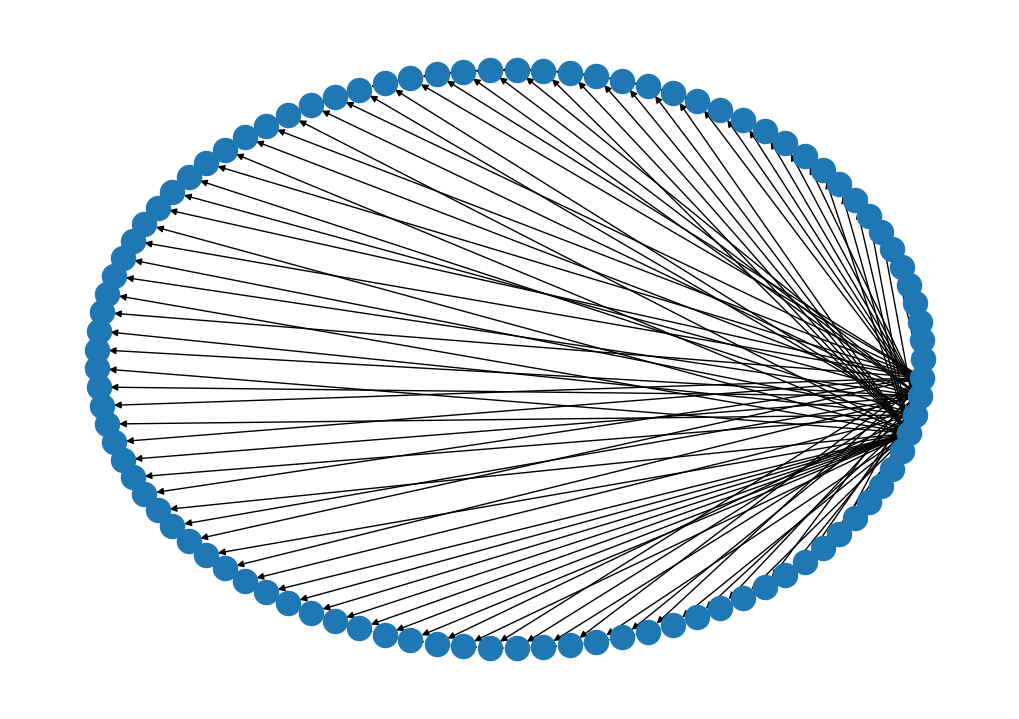

In [41]:
plt.figure(figsize=(10,7))
nx.draw_circular(g)

In [42]:
from torch_geometric.data import DataLoader

In [45]:
userIds=df16.user_id.unique()

In [49]:
df16.user_id.nunique()

1428

In [128]:
dataList=[]
for i in userIds:
    atomFeatures,loFeatures,loAtomEdgeIndex,atomEdgeIndex,y=user_dataset(i)
    data=generate_data(atomFeatures,loFeatures,loAtomEdgeIndex,loEdgeIndex,atomEdgeIndex,y)
    dataList.append(data)
torch.save(dataList, 'dataloader.pt')

In [129]:
dataset=torch.load('dataloader.pt')

In [130]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\mpathirana\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [131]:
model = GNN(hidden_channels=64, out_channels=2)
model = to_hetero(model, data.metadata(), aggr='mean')

In [132]:
optimizer=torch.optim.Adam(model.parameters(),lr=.01,weight_decay=5e-4)
criterion=torch.nn.CrossEntropyLoss()
def train_batch(data):
    model.train()
    optimizer.zero_grad()
    out=model(data.x_dict, data.edge_index_dict)
    #print(out)
    loss=criterion(out['atom'][data['atom'].train_mask],data['atom'].y[data['atom'].train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test_batch(data):
    model.eval()
    out=model(data.x_dict,data.edge_index_dict)
    #print(out)
    pred=out['atom'].argmax(dim=1)
    #print(out)
    test_correct=pred[data['atom'].test_mask]==data['atom'].y[data['atom'].test_mask]
    test_acc=int(test_correct.sum())/int(data['atom'].test_mask.sum())

   
    classificationReport=classification_report(data['atom'].y[data['atom'].test_mask],pred[data['atom'].test_mask])
    return test_acc

#for epcoh in range(1,501):
#    loss=train_batch()
#print('Epoch : {} , accuracy : {}'.format(epcoh,loss))
#    
#test_batch()

num_epochs=10
for epoch in range(num_epochs):
    for batch in enumerate loader:
        optimizer.zero_grad()

  
        data_batch=loader.dataset
        
        loss=train_batch(data_batch)
        print('Epoch : {} , accuracy : {}'.format(epcoh,loss))

In [135]:
for i, batch in enumerate( loader):
    
    data=batch
    model.train()
    optimizer.zero_grad()
    out=model(data.x_dict, data.edge_index_dict)
    #print(out)
    loss=criterion(out['atom'][data['atom'].train_mask],data['atom'].y[data['atom'].train_mask])
    loss.backward()
    optimizer.step()
    print('Epoch : {} , accuracy : {}'.format(i,loss))

Epoch : 0 , accuracy : 0.5987772345542908
Epoch : 1 , accuracy : 0.6452435851097107
Epoch : 2 , accuracy : 0.6116992831230164
Epoch : 3 , accuracy : 0.6076686382293701
Epoch : 4 , accuracy : 0.579174816608429
Epoch : 5 , accuracy : 0.663014829158783
Epoch : 6 , accuracy : 0.5474082827568054
Epoch : 7 , accuracy : 0.574768602848053
Epoch : 8 , accuracy : 0.5469696521759033
Epoch : 9 , accuracy : 0.5813412070274353
Epoch : 10 , accuracy : 0.5641095042228699
Epoch : 11 , accuracy : 0.5556538105010986
Epoch : 12 , accuracy : 0.5958717465400696
Epoch : 13 , accuracy : 0.6551903486251831
Epoch : 14 , accuracy : 0.5859590172767639
Epoch : 15 , accuracy : 0.5963006615638733
Epoch : 16 , accuracy : 0.5754773616790771
Epoch : 17 , accuracy : 0.5885976552963257
Epoch : 18 , accuracy : 0.5982117056846619
Epoch : 19 , accuracy : 0.5897283554077148
Epoch : 20 , accuracy : 0.6101229190826416
Epoch : 21 , accuracy : 0.6092498302459717
Epoch : 22 , accuracy : 0.6295072436332703
Epoch : 23 , accuracy : 

In [102]:
batch[ ('lo', 'lo_lo', 'lo')]

{'edge_index': tensor([[                   0,                    1, -9223372036854775808],
        [                   2,                    0,                    1]])}

In [115]:
dataset[3][ ('lo', 'lo_lo', 'lo')]

{'edge_index': tensor([[1, 0, 3],
        [2, 1, 0]])}

In [107]:
userIds[8]

'019f8b21-1059-4962-9cbc-70a978d14a79'

In [108]:
temp1=df16[df16.user_id==userIds[8]]

In [109]:
temp1

,graph_id,course_id,section_id,user_id,registration_id,goal_id,path_id,path_type,adaptive_behavior,topic_id,lo_to_concept_blacklist,interaction_end_time,concept_id,concept_partner_id,concept_name,retail_lo_id,learning_objective_name,atom_id,retail_atom_id,variation_id,sequence_created_at,parent_sequence_id,sequence_instance_id,sequence_ordinal,recommendation_id,source,state,type,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,work_remaining,status,target_status_and_progress,prev_concept_narrative,current_concept_narrative,focused_concept_id,prev_lo_narrative,current_lo_narrative,focused_lo_id,focused_topic_id,duration_s,is_target,loGraphID,difficulty,correctBinary
264,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,06d2aa87-6cc9-4a52-b708-bcc6a1515863,94d635a9-a09a-4aa4-89c0-ecdbe85be211,019f8b21-1059-4962-9cbc-70a978d14a79,12ca6d42-2996-4efc-8e7a-a2207783f7e5,14acf014-9c36-4d5c-b6d5-f629a99521aa,3ef83403-d033-40a7-8851-be8774e3f3e9,ADAPTIVE,PRACTICE,eefcbf2b-cbf8-4583-a294-e12cab893486,NaN,2022-11-10 01:40:11.206,507e7433-4327-4d0b-a087-e84696d0797d,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,4dcea1d1-bdd8-49b8-9cac-4abeb41697ad,0bd71b13-20f0-46cc-9f27-ccc14f4f6d8d,84022f93-114f-4d06-839f-b06d21827b2b,2022-11-08 21:09:07.417,efb50d37-de84-416c-ad1f-41f55ec55ca5,4082e92a-e1d6-455d-918a-7ccc7d1a56f9,1,6.995855e+18,RECOMMENDATION,DONE,ASSESS,False,0.000000,161.447006,0.061783,-1.0,in_progress,{'067b5973-e593-4ebd-9d42-c9ac276a7e02': {'pro...,DIRECT_CHOOSE_TOPIC,DIRECT_DIAGNOSE_TOPIC,507e7433-4327-4d0b-a087-e84696d0797d,NONE,NONE,aeaafe91-1194-495b-b7bc-d8ce8d0e72fe,tref-eefcbf2b-cbf8-4583-a294-e12cab893486,161.447006,True,16.0,0.826129,0
265,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,06d2aa87-6cc9-4a52-b708-bcc6a1515863,94d635a9-a09a-4aa4-89c0-ecdbe85be211,019f8b21-1059-4962-9cbc-70a978d14a79,12ca6d42-2996-4efc-8e7a-a2207783f7e5,14acf014-9c36-4d5c-b6d5-f629a99521aa,3ef83403-d033-40a7-8851-be8774e3f3e9,ADAPTIVE,PRACTICE,eefcbf2b-cbf8-4583-a294-e12cab893486,NaN,2022-11-10 01:43:43.363,507e7433-4327-4d0b-a087-e84696d0797d,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,81b2fc7e-39ea-46ce-b526-ba3bf96fc6af,e43a310b-5ee8-4348-84ef-ed19d4711672,96678e0d-22e0-4bd3-a7d0-9a030a40560c,2022-11-10 01:40:11.417,ceb0db9d-1142-4fed-8c84-ba2c3460d568,691038f2-82c6-473b-8b55-a0e60f2ddfb0,1,6.996285e+18,RECOMMENDATION,DONE,ASSESS,True,209.466995,2.466000,0.339130,-1.0,in_progress,{'067b5973-e593-4ebd-9d42-c9ac276a7e02': {'pro...,DIRECT_DIAGNOSE_TOPIC,DIRECT_DIAGNOSE_TOPIC,507e7433-4327-4d0b-a087-e84696d0797d,NONE,NONE,aeaafe91-1194-495b-b7bc-d8ce8d0e72fe,tref-eefcbf2b-cbf8-4583-a294-e12cab893486,211.932999,True,16.0,0.778523,1
266,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,06d2aa87-6cc9-4a52-b708-bcc6a1515863,94d635a9-a09a-4aa4-89c0-ecdbe85be211,019f8b21-1059-4962-9cbc-70a978d14a79,12ca6d42-2996-4efc-8e7a-a2207783f7e5,14acf014-9c36-4d5c-b6d5-f629a99521aa,3ef83403-d033-40a7-8851-be8774e3f3e9,ADAPTIVE,PRACTICE,eefcbf2b-cbf8-4583-a294-e12cab893486,NaN,2022-11-10 01:48:42.583,507e7433-4327-4d0b-a087-e84696d0797d,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,067b5973-e593-4ebd-9d42-c9ac276a7e02,Locate critical points using derivatives,20a54167-b791-4690-b658-c6916522c1d5,4a97c309-552d-4f31-b50b-99e6d3e876de,6f87f2ec-10a7-4a8c-b623-14cd38fa5203,2022-11-10 01:43:43.559,ae1c7b0e-a0dd-4fb3-bd82-801184b87347,d69bdc8b-c3a1-4b76-baca-8c33e60a88ac,1,6.996286e+18,RECOMMENDATION,DONE,ASSESS,True,226.744003,72.264000,0.750000,-1.0,in_progress,{'067b5973-e593-4ebd-9d42-c9ac276a7e02': {'pro...,DIRECT_DIAGNOSE_TOPIC,DIRECT_ASSESS_TOPIC,507e7433-4327-4d0b-a087-e84696d0797d,NONE,NONE,aeaafe91-1194-495b-b7bc-d8ce8d0e72fe,tref-eefcbf2b-cbf8-4583-a294-e12cab893486,299.007996,True,16.0,0.826009,1
267,076e1a0e-669c-40c4-a2

In [83]:
for i,b in enumerate(loader):
    if i<3:
      print(  b)

HeteroDataBatch(
  atom={
    x=[825, 1],
    y=[825],
    test_mask=[825],
    train_mask=[825],
    batch=[825],
    ptr=[33]
  },
  lo={
    x=[104, 1],
    batch=[104],
    ptr=[33]
  },
  (lo, lo_atom, atom)={ edge_index=[2, 825] },
  (lo, lo_lo, lo)={ edge_index=[2, 92] },
  (atom, atom_atom, atom)={ edge_index=[2, 793] }
)
HeteroDataBatch(
  atom={
    x=[920, 1],
    y=[920],
    test_mask=[920],
    train_mask=[920],
    batch=[920],
    ptr=[33]
  },
  lo={
    x=[115, 1],
    batch=[115],
    ptr=[33]
  },
  (lo, lo_atom, atom)={ edge_index=[2, 920] },
  (lo, lo_lo, lo)={ edge_index=[2, 94] },
  (atom, atom_atom, atom)={ edge_index=[2, 888] }
)
HeteroDataBatch(
  atom={
    x=[995, 1],
    y=[995],
    test_mask=[995],
    train_mask=[995],
    batch=[995],
    ptr=[33]
  },
  lo={
    x=[110, 1],
    batch=[110],
    ptr=[33]
  },
  (lo, lo_atom, atom)={ edge_index=[2, 995] },
  (lo, lo_lo, lo)={ edge_index=[2, 92] },
  (atom, atom_atom, atom)={ edge_index=[2, 963] }
)


class GCN(torch.nn.Module):
    def __init__(self,hidden_channels):
        super().__init__()
        torch.manual_seed(123)
        self.conv1=GCNConv(data.num_features,hidden_channels)
        self.conv2=GCNConv(hidden_channels,2)
    
    def forward(self,x,edge_index):
        x=self.conv1(x,edge_index)
        x=x.relu()
        x=F.drpout(x,p=.5,training=self.training)
        x=self.conv2(x,edge_index)
        return x
model=GCN(hidden_channels=5)
model = to_hetero(model, data.metadata(), aggr='sum')
print(model)

data['atom'].y[data['atom'].test_mask]

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class AtomClassificationModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(AtomClassificationModel, self).__init__()
        self.conv1 = pyg_nn.GCNConv(num_features, 16)
        self.conv2 = pyg_nn.GCNConv(16, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.softmax(x, dim=1)


class AtomClassificationModel(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(AtomClassificationModel, self).__init__(aggr='mean')  # Aggregation method for message passing
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Perform message passing
        return self.propagate(edge_index, x=x)

    def message(self, x_j, edge_index):
        # Step 3: Define the message passing function
        return x_j

    def update(self, aggr_out):
        # Step 4: Define the update function
        x = self.lin1(aggr_out)
        x = nn.functional.relu(x)
        x = self.lin2(x)
        return x


in_channels = data['atom'].x.size  # Number of input features for each atom
hidden_channels = 64  # Number of hidden units
out_channels = 2  # Number of output classes (assuming binary classification)

model = AtomClassificationModel(in_channels, hidden_channels, out_channels)


data['atom', 'atom_atom', 'atom']

x = data['atom'].x  # Atom features
edge_index = data['atom', 'atom_atom', 'atom'].edge_index  # Atom adjacency matrix

train_mask = data['atom'].train_mask  # Mask for training nodes
test_mask = data['atom'].test_mask  # Mask for testing nodes
y = data['atom'].y  # Labels

x_train = x[train_mask]
x_test = x[test_mask]
#edge_index_train = edge_index[:, train_mask]
#edge_index_test = edge_index[:, test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


import torch
from torch_geometric.nn import HeteroGraphConv, SAGEConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroGraphConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: torch.relu(x) for key, x in x_dict.items()}

        return self.lin(x_dict['atom'])

model = HeteroGNN(data.metadata(), hidden_channels=32, out_channels=data['atom'].y.size(-1), num_layers=2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[data['atom'].train_mask], data['atom'].y[data['atom'].train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=-1)
    correct = pred[data['atom'].test_mask] == data['atom'].y[data['atom'].test_mask]
    return correct.sum().item() / data['atom'].test_mask.sum().item()

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')



import torch
from torch_geometric.nn import HeteroGraphConv, SAGEConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroGraphConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata['edge_types']  # Update this based on your metadata structure
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: torch.relu(x) for key, x in x_dict.items()}

        return self.lin(x_dict['atom'])

# Example data and metadata
data = {
    'x_dict': {'atom': torch.tensor([1, 2, 3], dtype=torch.float)},  # Update with your actual data
    'edge_index_dict': {'atom': torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)},  # Update with your actual edge index
    'atom': {
        'y': torch.tensor([0, 1, 0], dtype=torch.long),  # Update with your actual labels
        'train_mask': torch.tensor([True, True, False], dtype=torch.bool),  # Update with your actual train mask
        'test_mask': torch.tensor([False, False, True], dtype=torch.bool),  # Update with your actual test mask
    },
}

metadata = {
    'edge_types': ['atom'],  # Update with your actual edge types
}

model = HeteroGNN(metadata, hidden_channels=32, out_channels=data['atom']['y'].size(-1), num_layers=2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data['x_dict'], data['edge_index_dict'])
    loss = criterion(out[data['atom']['train_mask']], data['atom']['y'][data['atom']['train_mask']])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data['x_dict'], data['edge_index_dict'])
    pred = out.argmax(dim=-1)
    correct = pred[data['atom']['test_mask']] == data['atom']['y'][data['atom']['test_mask']]
    return correct.sum().item() / data['atom']['test_mask'].sum().item()

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')


import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = SAGEConv(hidden_channels, hidden_channels)
            self.convs.append(conv)

        self.linears = torch.nn.ModuleDict()
        for key, num_channels in metadata['num_channels'].items():
            linear = Linear(hidden_channels, num_channels)
            self.linears[key] = linear

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = {
                key: conv(x_dict[key], edge_index_dict[key])
                for key in x_dict
            }
            x_dict = {
                key: F.relu(x)
                for key, x in x_dict.items()
            }

        for key, linear in self.linears.items():
            x_dict[key] = linear(x_dict[key])

        return x_dict['atom']

metadata = {
    'num_channels': {
        'atom': 32,  # Update with the desired number of channels for each edge type
    },
}

model = HeteroGNN(metadata, hidden_channels=32, out_channels=1, num_layers=2)



output = model(data['atom'], data['edge_index_dict'])
print(output)
